In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions, plotting_functions, hamiltonians
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonians import hamiltonian_3QD_1HH
from general_functions import solve_system
from plotting_functions import modify_plot, save_figure, zoomed_plot
from scipy.constants import h, e
from scipy.misc import derivative

In [3]:
h_eV = h / e  # Value for the Plank's constant [eV * s]
ET = (100 * np.pi)  # Zeeman splitting (ueV)
l1 = 0  # Spin-flip tunneling (ueV)
l2 = 0  # Spin-flip tunneling (ueV)
Omega0 = (100 * np.pi)  # * h_eV * 10 ** 6 * 10 ** 6  # Value for the tunelling parameter [mueV]
print(Omega0*h_eV * 10 ** 6 * 10 ** 6)
tf = 20 * (2 * np.pi) / Omega0  # ((100 * np.pi) * 10 ** 6) * 10 ** 9  # Final time [ns]
print(1* (2 * np.pi) / ((100 * np.pi) * 10 ** 6)* 10 ** 9)

# Parematers of the detunnings
tau = tf / 6
sigma = tau

1.2992583254344616
19.999999999999996


<IPython.core.display.Javascript object>


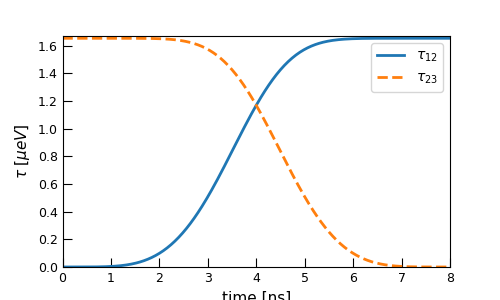

In [4]:
Omega12 = lambda t: Omega0 * np.exp(-(t - tf / 2 - tau) ** 2 / sigma ** 2)
Omega23 = lambda t: Omega0 * np.exp(-(t - tf / 2 + tau) ** 2 / sigma ** 2)

theta = lambda t: np.arctan(Omega12(t) / Omega23(t))
Omegaa = lambda t: derivative(theta, t, dx=1e-5)
phi = lambda t: np.arctan(Omegaa(t) / Omega12(t))
Omega12_tilda = lambda t: np.sqrt(Omega12(t) ** 2 + Omegaa(t) ** 2)
Omega23_tilda = lambda t: Omega23(t) - derivative(phi, t, dx=1e-5)

dx_derivative=1e-3
alpha0 = 400
chi = lambda t: np.pi * t / (2 * tf) - 1 / 3 * np.sin(2 * np.pi * t / tf) + 1 / 24 * np.sin(4 * np.pi * t / tf)
eta = lambda t: np.arctan(derivative(chi, t, dx=dx_derivative) / alpha0)
Omega12_tilde_SA = lambda t: derivative(eta, t, dx=dx_derivative) * np.cos(chi(t)) + derivative(chi, t, dx=dx_derivative) / (np.tan(eta(t))+1e-16) * np.sin(chi(t))
Omega23_tilde_SA = lambda t: derivative(chi, t, dx=dx_derivative) * np.cos(chi(t)) / (np.tan(eta(t))+1e-16) - derivative(eta, t, dx=dx_derivative) * np.sin(chi(t))

Omega12f_tilde_SA= lambda t: Omega12_tilde_SA(t)*0.4
Omega23f_tilde_SA= lambda t: Omega23_tilde_SA(t)*0.4

factor_mueV = h_eV * 10 ** 6 * 10 ** 6
factor_ns = (2 * np.pi) / ((100 * np.pi) * 10 ** 6)* 10 ** 9

time_step=1e-3
time = np.arange(0, tf+time_step, time_step)  # Time vector in which compute the solution of the population

fig, ax= plt.subplots()
fig.subplots_adjust(wspace=0.4)
ax.plot(time*factor_ns, Omega12_tilde_SA(time)*factor_mueV, label=r'$\tau_{12}$')
ax.plot(time*factor_ns, Omega23_tilde_SA(time)*factor_mueV, label=r'$\tau_{23}$')
ax.set_xlim([0, tf*factor_ns])
ax.set_ylim([0, np.max([Omega12_tilde_SA(time)*factor_mueV, Omega23_tilde_SA(time)*factor_mueV]) * 1.01])
ax.legend()
ax.set_xlabel('time [ns]')
ax.set_ylabel(r'$\tau\; [\mu eV]$')
modify_plot(ax,fig=fig,label_size=11, tick_label_size=9, lines_width=2, legend=True, legend_size=10,lines_bool=True, figsize=[5,3])
save_figure(fig,'STA_TQD_Pulses', overwrite=False);

In [5]:
density0 = np.zeros([6, 6], dtype=complex)  # Variable in which save the intitial density matrix
density0[0, 0] = 1  # The system intitiate in the state |↑,0,0>
parameters = [0, 0, 0, ET, Omega12_tilde_SA, Omega23_tilde_SA, Omega12f_tilde_SA,
              Omega23f_tilde_SA]  # List of parameters for the Hamiltonian (e1, e2, e3, EZ, tN12, tN23, tF12, tF23)
sol, prob, time = solve_system(time, density0, parameters, hamiltonian_3QD_1HH, prob=True, method='RK45', t_eval=False, hbar=1,
                              atol=1e-8, rtol=1e-6)  # Solve the evolution of the system

<IPython.core.display.Javascript object>


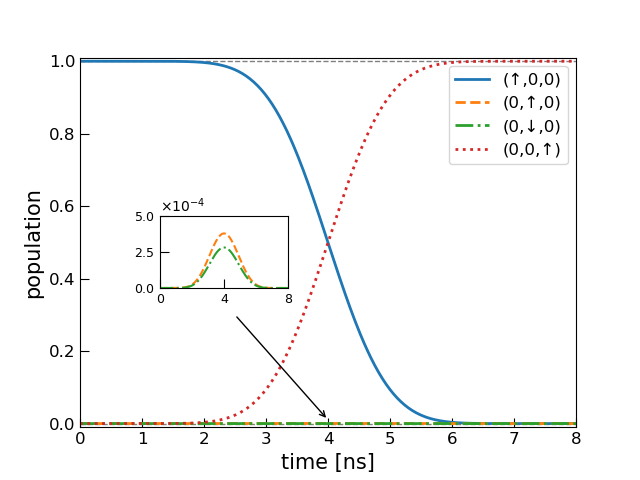

0.0006603641642297547


In [6]:
fig, ax= plt.subplots()
labels = ['(↑,0,0)', '(↓,0,0)', '(0,↑,0)', '(0,↓,0)', '(0,0,↑)', '(0,0,↓)']

ax.hlines(1, 0, tf*factor_ns, colors='grey', linestyle='--', linewidth=1)
ax.hlines(0, 0, tf*factor_ns, colors='grey', linestyle='--', linewidth=1)
for i in range(0, 6):
    if np.max(prob[:, i] > 10 ** (-4)):
        #if i !=0 and i!=4:
        ax.plot(time*factor_ns, prob[:, i], label=labels[i])

ax.legend()
ax.set_xlim([0, tf*factor_ns])
ax.set_ylim([-0.01, 1.01])
ax.set_xlabel('time [ns]')
ax.set_ylabel('population')
print(np.max(prob[:,2]+prob[:,3]))
modify_plot(ax, label_size=15, tick_label_size=12, lines_width=2, legend=True, legend_size=12,lines_bool=True)

ax_zoom=zoomed_plot(fig,ax,[0.25,0.4],[0.2,0.15],[time*factor_ns,prob[:, 2]], x_limit=[0,tf*factor_ns], y_limit=[0,0.0005],
                    color='tab:orange', line_style='--')
ax_zoom.plot(time*factor_ns,prob[:, 3],color='tab:green',linestyle='-.')
ax_zoom.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
#ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
modify_plot(ax_zoom, tick_label_size=9, lines_width=1.5,lines_bool=True, styles=False, x_ticks_vector=[0,4,8])
ax.annotate("", xy=(4,0.01), xytext=(2.5,0.3),arrowprops=dict(arrowstyle="->"))
save_figure(fig,'STA_TQD_Results', overwrite=False);

In [7]:
print(np.max(prob[:,1]+prob[:,2]+prob[:,3]+prob[:,5]))
print(np.max(prob[:,5]))
print(1-np.max(prob[:,4]))

0.000790542281342565
8.297643381623711e-05
9.702911807352166e-10


<IPython.core.display.Javascript object>


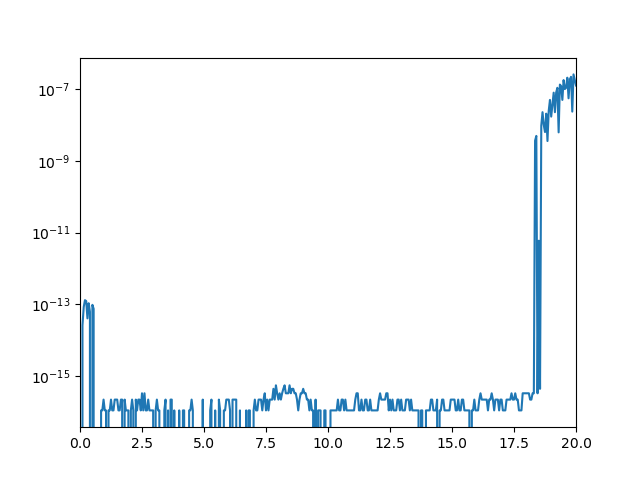

In [8]:
plt.figure()
plt.plot(time / (2 * np.pi / Omega0), np.abs(1 - np.sum(prob, axis=1)))
plt.yscale('log')
plt.xlim([0, tf / (2 * np.pi / Omega0)]);